# tf2 convolutional denoising autoencoder 로 MNIST Reconstruct 

* noise to the input

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU[0] is ready')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)
else:
    print('Please check GPU available')
    
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
import tensorflow_datasets as tfds
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY 

GPU[0] is ready


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D

# MNIST 데이터 확보

In [3]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
filters = [32,32,16]

In [4]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.   # [0-1] 사이
x_test = x_test / 255.     # [0-1] 사이

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise = 0.5
x_train_noisy = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0, 1)   # [0-1] 사이
x_test_noisy = np.clip(x_test_noisy, 0, 1)     # [0-1] 사이

x_train_noisy = x_train_noisy.astype(np.float32)
x_test_noisy = x_test_noisy.astype(np.float32)

x_train_noisy.shape

(60000, 28, 28, 1)

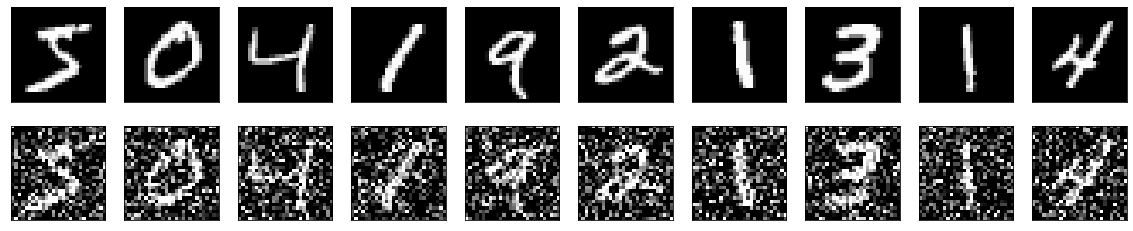

In [8]:
number = 10 
plt.figure(figsize=(20,4))
for index in range(number):
    # original
    ax = plt.subplot(2, number, index+1)
    plt.imshow(x_train[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # noisy
    ax = plt.subplot(2, number, index+1+number)  # 다음 줄
    plt.imshow(x_train_noisy[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 모델 정의

In [8]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, filters):
        super(Encoder, self).__init__()
        
        self.conv1 = Conv2D(filters[0], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.pool = MaxPooling2D((2,2), padding='same')
                
    def call(self, input_features):
        x = self.conv1(input_features)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        
        # encoder의 역순
        self.conv1 = Conv2D(filters[2], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv2 = Conv2D(filters[1], kernel_size=3, strides=1, activation='relu', padding='same')
        self.conv3 = Conv2D(filters[0], kernel_size=3, strides=1, activation='relu', padding='valid')
        
        self.conv4 = Conv2D(1, 3, 1, activation='sigmoid', padding='same')
        self.upsample = UpSampling2D((2,2))
        
    def call(self, encoded):
        x = self.conv1(encoded)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        return x
    
class Autoencoder(tf.keras.Model):
    
    def __init__(self, filters):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(filters)
        self.decoder = Decoder(filters)
        
    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed
    

autoencoder = Autoencoder(filters)
autoencoder.build(input_shape=(None, 28, 28, 1))
autoencoder.call(tf.keras.layers.Input(shape = (28, 28, 1)))
autoencoder.summary()  

Model: "autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          (None, 4, 4, 16)          14192     
_________________________________________________________________
decoder_1 (Decoder)          (None, 28, 28, 1)         16497     
Total params: 30,689
Trainable params: 30,689
Non-trainable params: 0
_________________________________________________________________


# 학습

In [9]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

loss = autoencoder.fit(x_train_noisy,
    x_train,
    validation_data=(x_test_noisy, x_test),
    epochs=max_epochs,
    batch_size=batch_size)

Epoch 1/50
235/235 [==============================] - 2s 7ms/step - loss: 0.2418 - val_loss: 0.1717
Epoch 2/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1600 - val_loss: 0.1494
Epoch 3/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1444 - val_loss: 0.1375
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1356 - val_loss: 0.1307
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1297 - val_loss: 0.1280
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1258 - val_loss: 0.1226
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1228 - val_loss: 0.1200
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1205 - val_loss: 0.1183
Epoch 9/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1181 - val_loss: 0.1160
Epoch 10/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1165 - val_loss: 0.1146

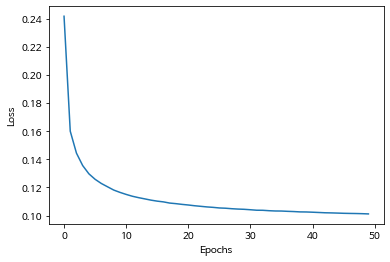

In [10]:
plt.plot(range(max_epochs), loss.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Reconstruct 시각화

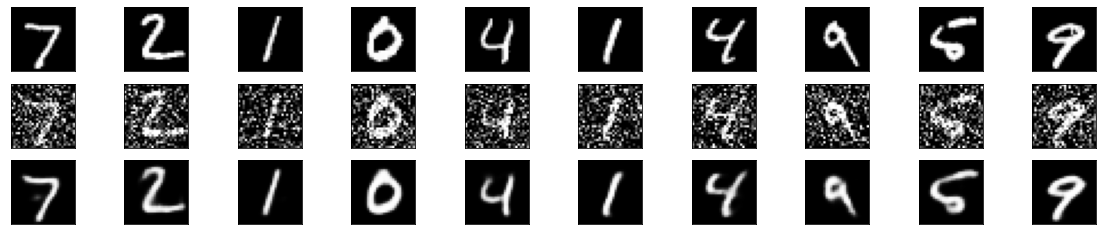

In [11]:
number = 10 
plt.figure(figsize=(20,4))
for index in range(number):
    # original
    ax = plt.subplot(3, number, index+1)
    plt.imshow(x_test[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # noisy
    ax = plt.subplot(3, number, index+1+number)
    plt.imshow(x_test_noisy[index].reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstructed
    ax = plt.subplot(3, number, index+1+number*2)  # 다음 줄
    plt.imshow(autoencoder(x_test_noisy)[index].numpy().reshape(28,28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()